# Frame 2 action - Initial walkthrough
## Predict played action from frame sequences

In [1]:
import numpy as np           
import tensorflow as tf
import f2alib
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])  # n00bz who dont
f2alib.init_basic_env()  # init basic environment

## Check pre-processing and test an episode

Play episode and return pre-processed frames. Replay episode if number of frames is little.

In [2]:
frames, labels = f2alib.play_episode()
len(frames)

/Users/tommasobiancalani/anaconda3/envs/py27-dqdoom/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/tommasobiancalani/anaconda3/envs/py27-dqdoom/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


240

Display some randomly-chosen frames and corresponding action performed. 

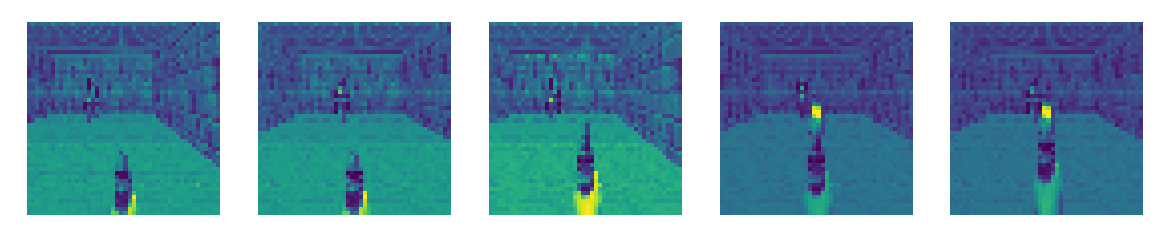

In [3]:
n_frames = 5
fig, axs = plt.subplots(ncols=n_frames, figsize=(20, 10))
ixs = list(np.random.choice(range(len(frames)), size=n_frames))
for ax,ix in zip(axs, ixs):
    ax.axis('off')
    ax.imshow(frames[ix])
    ax.set_title('Frame: ' + str(ix) + ' Action: ' + str(labels[ix]))

Display first frames

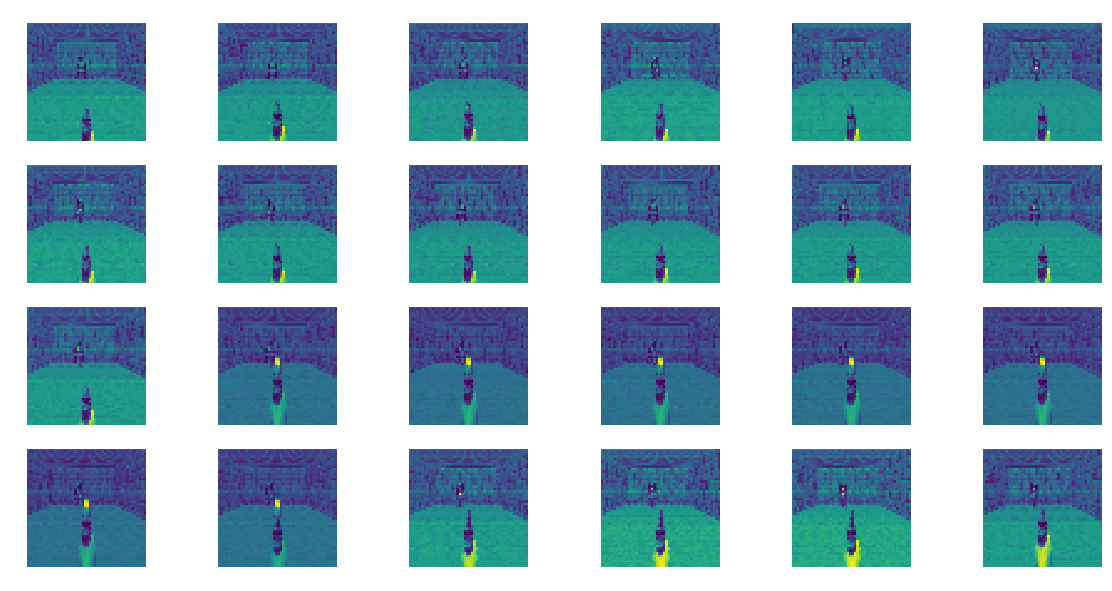

In [4]:
n_frames = 6 # per row
n_rows = 4
ixs = range(n_frames*n_rows)
fig, axs = plt.subplots(ncols=n_frames, nrows=n_rows, figsize=(20, 10))
for coord, ix in enumerate(ixs):
    coord = np.unravel_index(coord, dims=(n_rows, n_frames)) # there must be a simpler way
    axs[coord].axis('off')
    axs[coord].imshow(frames[ix])
    axs[coord].set_title('Frame: ' + str(ix) + ' Action: ' + str(labels[ix]))

Display last frames

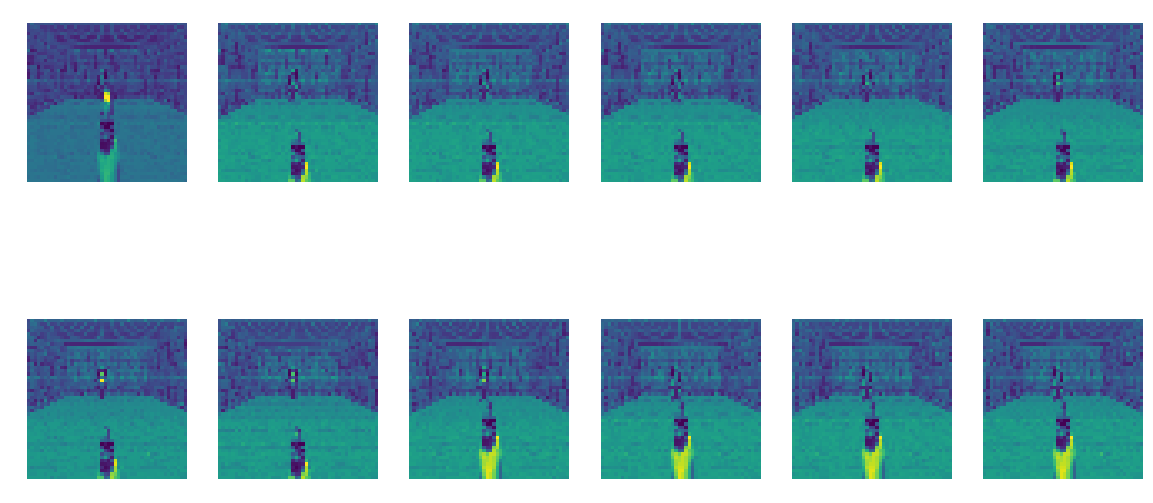

In [5]:
n_frames = 6 # per row
n_rows = 2
ixs = reversed(range(len(frames)-(n_frames*n_rows), len(frames)))
fig, axs = plt.subplots(ncols=n_frames, nrows=n_rows, figsize=(20, 10))
for coord, ix in enumerate(ixs):
    coord = np.unravel_index(coord, dims=(n_rows, n_frames)) # there must be a simpler way
    axs[coord].axis('off')
    axs[coord].imshow(frames[ix])
    axs[coord].set_title('Frame: ' + str(ix) + ' Action: ' + str(labels[ix]))

The goal of the NN is to predict the sequence of actions played, given a short part of the episode replay. To each frame we stack the 5 next ones (for a total of six) and annotate the corresponding action as the one from the first frame. Each stack corresponds to a training example.

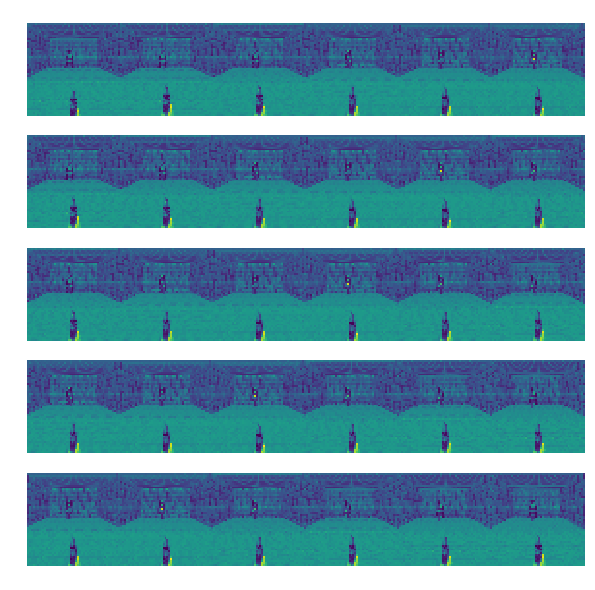

In [6]:
history_length=6
stacks = f2alib.stack_frames(frames, history_length)
labels = labels[:-history_length]
fig, axs = plt.subplots(nrows=5, figsize=(10, 10))
for ix, ax in enumerate(axs):
    ax.axis('off')
    ax.set_title('Action: '+str(labels[ix]))
    ax.imshow(stacks[ix])

## Further pre-process and feed into simple CNN

Load simple model and print architecture

In [8]:
model = f2alib.f2a_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 286, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 143, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 141, 32)       9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 70, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 68, 32)         9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 22, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
__________

In [9]:
assert len(labels) == len(stacks)

Pre-process stack to add a fourth dummy dim

In [10]:
new_shape = stacks.shape + (1,) # add fourth dummy dim
stacks = np.reshape(stacks, new_shape)
stacks.shape

(234, 48, 288, 1)

1-hot encoding of action labels (dummy trap not accounted for)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
le = LabelEncoder()
oh = OneHotEncoder()
labels_le = le.fit_transform(labels)
labels_le = np.reshape(labels_le, (-1, 1))
labels_le.shape
labels_oh = oh.fit_transform(labels_le)
labels_oh.shape

/Users/tommasobiancalani/anaconda3/envs/py27-dqdoom/lib/python2.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(234, 3)

Fit model to our small training set

In [12]:
model.fit(stacks, labels_oh, epochs=1, batch_size=64);

Epoch 1/1
234/234 [==============================] - 4s 16ms/step - loss: 1.0982 - acc: 0.2906


Get larger dataset by playing many episodes. Note that dummy image shape is already fixed.

In [13]:
images, labels = f2alib.get_images_labels(1000)
images.shape, labels.shape

((1063, 48, 288, 1), (1063,))

Finally, one-hot encode labels

In [14]:
f2alib.oh_labels(labels)

<1063x3 sparse matrix of type '<type 'numpy.float64'>'
	with 1063 stored elements in Compressed Sparse Row format>